# Importing the used libraries

In [2]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

# Classifying the used datasets

In [3]:
data_dir = "../input/original-dataset/PlantaeK dataset classified/test"
Num_classes = os.listdir(data_dir)
print(Num_classes)
print("Total Number of classes are: {}".format(len(Num_classes)))

['GRAPES_healthy', 'PEAR_diseased', 'WALNUT_healthy', 'CHERRY_diseased', 'CHERRY_healthy', 'CRANBERRY_healthy', 'PEACH_diseased', 'PEACH_healthy', 'Apple_healthy', 'APRICOT_healthy', 'WALNUT_diseased', 'Apple_diseased', 'APRICOT_diseased', 'CRANBERRY_diseased', 'GRAPES_diseased', 'PEAR_healthy']
Total Number of classes are: 16


In [4]:
plant_species_class_size = {}
for species in Num_classes:
    plant_species_class_size[species] = len(os.listdir(data_dir + '/' + species))

Text(0.5, 1.0, 'Images per each class of plant species')

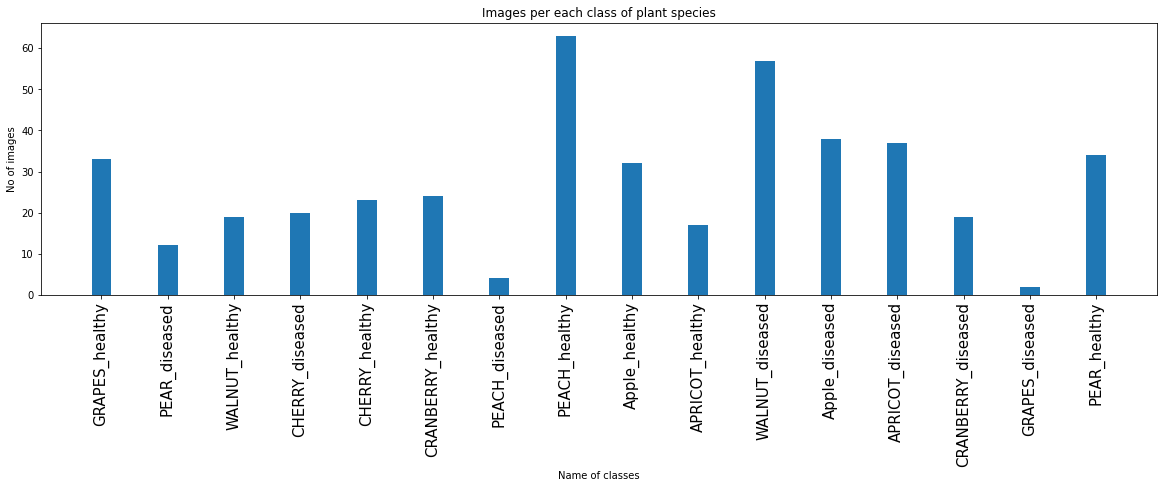

In [5]:
index = [n for n in range(16)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in plant_species_class_size.values()], width=0.3)
plt.xlabel('Name of classes', fontsize=10)
plt.ylabel('No of images', fontsize=10)
plt.xticks(index, Num_classes, fontsize=15, rotation=90)
plt.title('Images per each class of plant species')

## Data Preprocessing

In [6]:
Data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '../input/original-dataset/PlantaeK dataset classified'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=Data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=32)
               for x in ['train', 'val', 'test']}
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

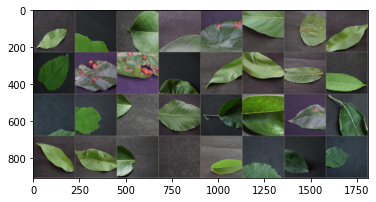

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(images)
imshow(out)

## Define a function for training and evaluating the model

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Downloading the pretrained models

# VGG-16 Architecture

In [69]:
model_vgg16 = models.vgg16(pretrained=True)

In [70]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [71]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2152 Acc: 0.3251
val Loss: 1.7193 Acc: 0.5600

Epoch 1/19
----------
train Loss: 1.5631 Acc: 0.5648
val Loss: 1.4521 Acc: 0.5600

Epoch 2/19
----------
train Loss: 1.3552 Acc: 0.6075
val Loss: 1.2977 Acc: 0.6171

Epoch 3/19
----------
train Loss: 1.2241 Acc: 0.6516
val Loss: 1.2370 Acc: 0.6400

Epoch 4/19
----------
train Loss: 1.1367 Acc: 0.6593
val Loss: 1.1799 Acc: 0.6571

Epoch 5/19
----------
train Loss: 1.1091 Acc: 0.6632
val Loss: 1.1827 Acc: 0.6286

Epoch 6/19
----------
train Loss: 1.0618 Acc: 0.6788
val Loss: 1.1348 Acc: 0.6343

Epoch 7/19
----------
train Loss: 1.0199 Acc: 0.6904
val Loss: 1.1238 Acc: 0.6514

Epoch 8/19
----------
train Loss: 0.9969 Acc: 0.7092
val Loss: 1.1206 Acc: 0.6514

Epoch 9/19
----------
train Loss: 1.0114 Acc: 0.6904
val Loss: 1.1268 Acc: 0.6571

Epoch 10/19
----------
train Loss: 0.9880 Acc: 0.7040
val Loss: 1.1221 Acc: 0.6514

Epoch 11/19
----------
train Loss: 0.9836 Acc: 0.7021
val Loss: 1.1150 Acc: 0.6514

Ep

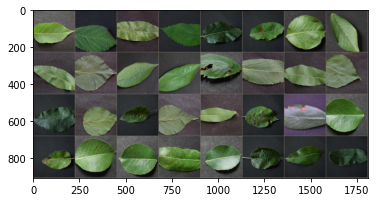

GroundTruth:  WALNUT_healthy, CRANBERRY_healthy, PEACH_healthy, GRAPES_healthy, Apple_healthy, Apple_diseased, PEAR_diseased, CHERRY_healthy, PEACH_healthy, APRICOT_diseased, CHERRY_healthy, CHERRY_healthy, CHERRY_diseased, WALNUT_diseased, PEACH_healthy, APRICOT_diseased, Apple_diseased, APRICOT_diseased, Apple_diseased, APRICOT_diseased, PEACH_healthy, Apple_diseased, CHERRY_diseased, PEAR_healthy, Apple_diseased, PEAR_diseased, PEAR_diseased, PEAR_diseased, PEAR_healthy, Apple_diseased, Apple_healthy, Apple_healthy
Predicted:  WALNUT_healthy, Apple_diseased, PEACH_healthy, GRAPES_healthy, PEAR_healthy, CRANBERRY_healthy, PEAR_healthy, CHERRY_healthy, PEACH_healthy, APRICOT_diseased, PEACH_healthy, CHERRY_healthy, WALNUT_diseased, WALNUT_diseased, PEACH_healthy, APRICOT_diseased, Apple_diseased, APRICOT_diseased, Apple_diseased, APRICOT_diseased, PEACH_healthy, Apple_diseased, CHERRY_diseased, PEAR_healthy, Apple_diseased, PEAR_healthy, PEAR_healthy, PEAR_healthy, PEAR_healthy, Apple

In [72]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_vgg16(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

In [73]:
plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('steps')
    plt.plot(best_acc)
    plt.show()

IndentationError: unexpected indent (2449506991.py, line 2)

# ResNet-18 Architecture

In [10]:
model_resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_resnet = train_model(model_resnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.2866 Acc: 0.3335
val Loss: 1.7905 Acc: 0.5714

Epoch 1/19
----------
train Loss: 1.5142 Acc: 0.6315
val Loss: 1.3728 Acc: 0.6743

Epoch 2/19
----------
train Loss: 1.1610 Acc: 0.7396
val Loss: 1.2151 Acc: 0.6857

Epoch 3/19
----------
train Loss: 0.9673 Acc: 0.7869
val Loss: 1.1350 Acc: 0.7086

Epoch 4/19
----------
train Loss: 0.8822 Acc: 0.8012
val Loss: 1.0214 Acc: 0.7029

Epoch 5/19
----------
train Loss: 0.7908 Acc: 0.7992
val Loss: 1.0055 Acc: 0.7029

Epoch 6/19
----------
train Loss: 0.7175 Acc: 0.8348
val Loss: 0.9671 Acc: 0.7200

Epoch 7/19
----------
train Loss: 0.7275 Acc: 0.8135
val Loss: 0.9731 Acc: 0.7029

Epoch 8/19
----------
train Loss: 0.6926 Acc: 0.8316
val Loss: 0.9732 Acc: 0.7143

Epoch 9/19
----------
train Loss: 0.7003 Acc: 0.8297
val Loss: 0.9771 Acc: 0.7200

Epoch 10/19
----------
train Loss: 0.6792 Acc: 0.8361
val Loss: 0.9492 Acc: 0.7086

Epoch 11/19
----------
train Loss: 0.6747 Acc: 0.8310
val Loss: 0.9677 Acc: 0.7200

Ep

In [13]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

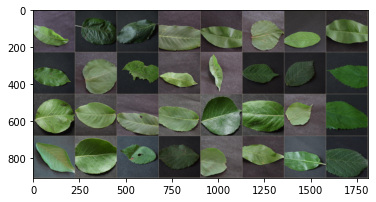

GroundTruth:  PEACH_healthy, Apple_diseased, Apple_diseased, WALNUT_diseased, PEACH_healthy, APRICOT_diseased, CHERRY_healthy, PEACH_healthy, Apple_diseased, APRICOT_diseased, GRAPES_healthy, PEACH_healthy, PEACH_healthy, CRANBERRY_healthy, CRANBERRY_healthy, GRAPES_healthy, PEAR_diseased, WALNUT_healthy, WALNUT_diseased, WALNUT_diseased, PEAR_healthy, PEAR_healthy, APRICOT_diseased, GRAPES_healthy, CHERRY_healthy, PEAR_healthy, CRANBERRY_diseased, CRANBERRY_diseased, APRICOT_healthy, PEACH_healthy, Apple_healthy, CRANBERRY_healthy
Predicted:  PEACH_healthy, Apple_diseased, Apple_healthy, WALNUT_diseased, PEACH_healthy, APRICOT_diseased, CHERRY_healthy, PEACH_healthy, CRANBERRY_diseased, APRICOT_diseased, GRAPES_healthy, PEACH_healthy, PEACH_healthy, CRANBERRY_healthy, CRANBERRY_healthy, GRAPES_healthy, PEAR_healthy, WALNUT_healthy, WALNUT_diseased, WALNUT_diseased, PEAR_healthy, PEAR_healthy, APRICOT_diseased, GRAPES_healthy, WALNUT_healthy, PEAR_healthy, CRANBERRY_diseased, CRANBERRY

In [14]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_resnet(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

In [ ]:
 plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('steps')
    plt.plot(best_acc)
    plt.show()

### AlexNet Architecture

In [15]:
model_alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [16]:
for param in model_alexnet.parameters():
    param.requires_grad = False

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_alexnet = train_model(model_alexnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.5276 Acc: 0.5233
val Loss: 1.0532 Acc: 0.6171

Epoch 1/19
----------
train Loss: 0.8442 Acc: 0.7273
val Loss: 1.0732 Acc: 0.6686

Epoch 2/19
----------
train Loss: 0.7158 Acc: 0.7597
val Loss: 1.0289 Acc: 0.7086

Epoch 3/19
----------
train Loss: 0.7225 Acc: 0.7513
val Loss: 0.9006 Acc: 0.7029

Epoch 4/19
----------
train Loss: 0.6039 Acc: 0.7902
val Loss: 0.9760 Acc: 0.6743

Epoch 5/19
----------
train Loss: 0.6394 Acc: 0.7727
val Loss: 1.0933 Acc: 0.7029

Epoch 6/19
----------
train Loss: 0.5985 Acc: 0.7979
val Loss: 1.0072 Acc: 0.7143

Epoch 7/19
----------
train Loss: 0.5851 Acc: 0.7895
val Loss: 0.8620 Acc: 0.7086

Epoch 8/19
----------
train Loss: 0.5868 Acc: 0.7927
val Loss: 0.8680 Acc: 0.7029

Epoch 9/19
----------
train Loss: 0.5565 Acc: 0.8070
val Loss: 0.8782 Acc: 0.7200

Epoch 10/19
----------
train Loss: 0.5149 Acc: 0.8219
val Loss: 0.8753 Acc: 0.7143

Epoch 11/19
----------
train Loss: 0.5460 Acc: 0.8096
val Loss: 0.8807 Acc: 0.7200

Ep

In [ ]:
model_alexnet

### Test the model

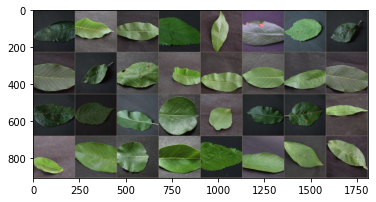

GroundTruth:  Apple_diseased, WALNUT_healthy, PEACH_healthy, GRAPES_healthy, PEACH_healthy, CHERRY_diseased, CRANBERRY_diseased, Apple_healthy, WALNUT_diseased, Apple_diseased, CHERRY_diseased, PEACH_healthy, PEACH_healthy, WALNUT_healthy, PEACH_healthy, WALNUT_diseased, Apple_diseased, CRANBERRY_healthy, Apple_healthy, PEAR_healthy, APRICOT_diseased, Apple_healthy, Apple_diseased, PEACH_healthy, PEACH_healthy, CHERRY_healthy, PEAR_healthy, PEAR_healthy, GRAPES_healthy, CHERRY_healthy, CHERRY_healthy, PEACH_healthy
Predicted:  Apple_diseased, WALNUT_healthy, PEACH_healthy, GRAPES_healthy, PEACH_healthy, CHERRY_diseased, CRANBERRY_healthy, Apple_diseased, WALNUT_diseased, Apple_diseased, CHERRY_diseased, PEACH_healthy, PEACH_healthy, WALNUT_healthy, PEACH_healthy, WALNUT_diseased, Apple_diseased, Apple_diseased, Apple_healthy, PEAR_healthy, APRICOT_diseased, Apple_healthy, Apple_diseased, CHERRY_healthy, PEACH_healthy, CHERRY_healthy, PEAR_healthy, PEAR_healthy, GRAPES_healthy, CHERRY_h

In [18]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_alexnet(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

In [ ]:
  plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('steps')
    plt.plot(best_acc)
    plt.show()